In [3]:
# Importing the necessary library's

import pandas as pd
import base64
import os
from requests import get, post
import json
import time

In [2]:
# Reading the dataset and creating a dataframe

df = pd.read_csv('charts.csv')
print(df.head(3))

                         title  rank        date        artist  \
0      Chantaje (feat. Maluma)     1  2017-01-01       Shakira   
1  Vente Pa' Ca (feat. Maluma)     2  2017-01-01  Ricky Martin   
2   Reggaetón Lento (Bailemos)     3  2017-01-01          CNCO   

                                                 url     region   chart  \
0  https://open.spotify.com/track/6mICuAdrwEjh6Y6...  Argentina  top200   
1  https://open.spotify.com/track/7DM4BPaS7uofFul...  Argentina  top200   
2  https://open.spotify.com/track/3AEZUABDXNtecAO...  Argentina  top200   

           trend   streams  
0  SAME_POSITION  253019.0  
1        MOVE_UP  223988.0  
2      MOVE_DOWN  210943.0  


In [12]:
# Filtering the dataframe and using the country United States only

df = df[df['region'] == 'United States']
df = df[df['chart'] == 'top200']
df['title_id'] = df['url'].str[31:]

# Run only for charts_US
# df.to_csv('charts_US.csv', index=False)
# print(len(df))

364184


In [15]:
print(df.head())

                                    title  rank        date  \
8246  Bad and Boujee (feat. Lil Uzi Vert)     1  2017-01-01   
8247                            Fake Love     2  2017-01-01   
8248                              Starboy     3  2017-01-01   
8249                               Closer     4  2017-01-01   
8250                        Black Beatles     5  2017-01-01   

                        artist  \
8246                     Migos   
8247                     Drake   
8248     The Weeknd, Daft Punk   
8249  The Chainsmokers, Halsey   
8250  Rae Sremmurd, Gucci Mane   

                                                    url         region  \
8246  https://open.spotify.com/track/4Km5HrUvYTaSUfi...  United States   
8247  https://open.spotify.com/track/343YBumqHu19cGo...  United States   
8248  https://open.spotify.com/track/5aAx2yezTd8zXrk...  United States   
8249  https://open.spotify.com/track/7BKLCZ1jbUBVqRi...  United States   
8250  https://open.spotify.com/track/6fujklziT

In [16]:
# Droppinf duplicate values

df = df.drop_duplicates(subset=['title','artist'], keep='first')
print(len(df))

12683


In [6]:
# Do NOT RUN THIS CELL
# Run from this cell only to fill in data for missing values for missing.csv

df = pd.read_csv('missing.csv')

In [7]:
# Creating a column 'track_id'

df['title_id'] = df['url'].str[31:]
print(df.head())

   Unnamed: 0                                title  \
0          34                         All Time Low   
1          92     I Knew You Were Waiting (For Me)   
2         404                     Careless Whisper   
3         402                                Moves   
4         437  Bad and Boujee (feat. Lil Uzi Vert)   

                            artist  \
0                      JON BELLION   
1  GEORGE MICHAEL, ARETHA FRANKLIN   
2                   GEORGE MICHAEL   
3                         BIG SEAN   
4                            MIGOS   

                                                 url                title_id  
0  https://open.spotify.com/track/5wQRNkb7OhzJoT1...  5wQRNkb7OhzJoT1P0OZ4Rw  
1  https://open.spotify.com/track/0f6pHbsLzpWxl5C...  0f6pHbsLzpWxl5CfhOUjBA  
2  https://open.spotify.com/track/6KsgCYcZKPcBRDN...  6KsgCYcZKPcBRDNGhiZWRR  
3  https://open.spotify.com/track/6Kd4EPrY9A4WBUF...  6Kd4EPrY9A4WBUFy5JaqEc  
4  https://open.spotify.com/track/1FvU97lrWOG2NRx..

In [8]:
# Spotify Credentials for generating token

client_id = "c392d42a11bf414182f69a9e40526bc6"
client_secret = "fde1f03252d749319749f55473ee2247"

print(client_id, client_secret)

def get_token():
      auth_string = client_id + ":" + client_secret
      auth_bytes = auth_string.encode("utf-8")
      auth_base64 = str(base64.b64encode(auth_bytes), "utf-8")
      url = "https://accounts.spotify.com/api/token"
      headers = {
          "Authorization": "Basic " + auth_base64,
          "Content-Type": "application/x-www-form-urlencoded"
      }
      data = {"grant_type": "client_credentials"}
      result = post(url, headers=headers, data=data)
      json_result = json.loads (result.content)
      token = json_result["access_token"]
      return token

def get_auth_header (token):
    return {"Authorization": "Bearer " + token}

c392d42a11bf414182f69a9e40526bc6 fde1f03252d749319749f55473ee2247


In [9]:
# getting Audio Features Function

i= 0

def get_track_audio_features(token, track_id):
    query_url = 'https://api.spotify.com/v1/audio-features?ids=' + track_id
    headers = get_auth_header(token)
    try:
        result = get(query_url, headers=headers)
    except ConnectionError as ce:
        i = i + 1
        print(f"Time limit exceeded for the {i}th time")
        time.sleep(120)
        token = get_token()
        return get_track_audio_features(token, track_id)
    if result.status_code != 200:
        print("Error Received for the following query: ")
        print("\n")
        print(query_url)
        print("\n")
        return ""
        
    json_result = json.loads(result.content)
    return json_result

In [10]:
# Concatenating track_ID's to reduce the no of API calls, by sending 50 ID's in 1 API call.

concatenated_track_ids = []

for i in range(0, len(df['title_id']), 100):
    concatenated_ids = ','.join(df['title_id'].iloc[i:i+100])
    concatenated_track_ids.append(concatenated_ids)

print(len(concatenated_track_ids))

20


In [11]:
# Creating a list for audio features of all the title_id's

audio_features_list = []

for s in concatenated_track_ids:
    token = get_token()
    obj = get_track_audio_features(token, s)
    for item in obj['audio_features']:
        audio_features_list.append(item)

print(len(audio_features_list))

1977


In [12]:
print(audio_features_list[1])

{'danceability': 0.71, 'energy': 0.639, 'key': 4, 'loudness': -12.839, 'mode': 1, 'speechiness': 0.045, 'acousticness': 0.23, 'instrumentalness': 0, 'liveness': 0.172, 'valence': 0.733, 'tempo': 107.947, 'type': 'audio_features', 'id': '0f6pHbsLzpWxl5CfhOUjBA', 'uri': 'spotify:track:0f6pHbsLzpWxl5CfhOUjBA', 'track_href': 'https://api.spotify.com/v1/tracks/0f6pHbsLzpWxl5CfhOUjBA', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/0f6pHbsLzpWxl5CfhOUjBA', 'duration_ms': 241000, 'time_signature': 4}


In [13]:
print(df.head())

   Unnamed: 0                                title  \
0          34                         All Time Low   
1          92     I Knew You Were Waiting (For Me)   
2         404                     Careless Whisper   
3         402                                Moves   
4         437  Bad and Boujee (feat. Lil Uzi Vert)   

                            artist  \
0                      JON BELLION   
1  GEORGE MICHAEL, ARETHA FRANKLIN   
2                   GEORGE MICHAEL   
3                         BIG SEAN   
4                            MIGOS   

                                                 url                title_id  
0  https://open.spotify.com/track/5wQRNkb7OhzJoT1...  5wQRNkb7OhzJoT1P0OZ4Rw  
1  https://open.spotify.com/track/0f6pHbsLzpWxl5C...  0f6pHbsLzpWxl5CfhOUjBA  
2  https://open.spotify.com/track/6KsgCYcZKPcBRDN...  6KsgCYcZKPcBRDNGhiZWRR  
3  https://open.spotify.com/track/6Kd4EPrY9A4WBUF...  6Kd4EPrY9A4WBUFy5JaqEc  
4  https://open.spotify.com/track/1FvU97lrWOG2NRx..

In [14]:
# Creating new columns in the df and populating them with their corresponding values from audio_features_list

df['danceability'] = None
df['energy'] = None
df['key'] = None
df['loudness'] = None
df['mode'] = None
df['speechiness'] = None
df['acousticness'] = None
df['instrumentalness'] = None
df['liveness'] = None
df['valence'] = None
df['tempo'] = None
df['duration_ms'] = None
df['time_signature'] = None

for i, obj in enumerate(audio_features_list):
    # print(f"For {i} -> {obj}")
    df['danceability'].iloc[i] = obj['danceability']
    df['energy'].iloc[i] = obj['energy']
    df['key'].iloc[i] = obj['key']
    df['loudness'].iloc[i] = obj['loudness']
    df['mode'].iloc[i] = obj['mode']
    df['speechiness'].iloc[i] = obj['speechiness']
    df['acousticness'].iloc[i] = obj['acousticness']
    df['instrumentalness'].iloc[i] = obj['instrumentalness']
    df['liveness'].iloc[i] = obj['liveness']
    df['valence'].iloc[i] = obj['valence']
    df['tempo'].iloc[i] = obj['tempo']
    df['duration_ms'].iloc[i] = obj['duration_ms']
    df['time_signature'].iloc[i] = obj['time_signature']

/var/folders/by/10tpw0f1017d0jnlxgmb7qtm0000gn/T/ipykernel_36714/973579132.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['danceability'].iloc[i] = obj['danceability']
/var/folders/by/10tpw0f1017d0jnlxgmb7qtm0000gn/T/ipykernel_36714/973579132.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['energy'].iloc[i] = obj['energy']
/var/folders/by/10tpw0f1017d0jnlxgmb7qtm0000gn/T/ipykernel_36714/973579132.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

In [15]:
print(df.head(3))

   Unnamed: 0                             title  \
0          34                      All Time Low   
1          92  I Knew You Were Waiting (For Me)   
2         404                  Careless Whisper   

                            artist  \
0                      JON BELLION   
1  GEORGE MICHAEL, ARETHA FRANKLIN   
2                   GEORGE MICHAEL   

                                                 url                title_id  \
0  https://open.spotify.com/track/5wQRNkb7OhzJoT1...  5wQRNkb7OhzJoT1P0OZ4Rw   
1  https://open.spotify.com/track/0f6pHbsLzpWxl5C...  0f6pHbsLzpWxl5CfhOUjBA   
2  https://open.spotify.com/track/6KsgCYcZKPcBRDN...  6KsgCYcZKPcBRDNGhiZWRR   

  danceability energy key loudness mode speechiness acousticness  \
0        0.672  0.386   0   -9.715    1       0.264        0.389   
1         0.71  0.639   4  -12.839    1       0.045         0.23   
2        0.567   0.32   2  -18.386    0       0.036        0.345   

  instrumentalness liveness valence    tempo dur

In [16]:
# Creating a csv file for the same
df.dropna(subset=['title','artist'], inplace = True)
df.to_csv('charts_US_attributes_missing.csv', index=False)

# PART 2

In [4]:
import ast
df = pd.read_csv('result.csv')

# Setting chart200 only
df = df[df['chart'] == 'top200']

# Sorting by date and rank
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by=['date', 'rank'])

df['album_names'] = df['album_names'].apply(ast.literal_eval)
df['album_names_count'] = df['album_names'].apply(lambda x: len(x) if isinstance(x, list) else 0)

df['release_dates'] = df['release_dates'].apply(ast.literal_eval)
df['release_dates_count'] = df['release_dates'].apply(lambda x: len(x) if isinstance(x, list) else 0)

print(df.head(3))

                            title  rank       date                   artist  \
0                       Rich Girl    98 2017-01-01  DARYL HALL & JOHN OATES   
1  You Make My Dreams (Come True)   105 2017-01-01  DARYL HALL & JOHN OATES   
2    Twist And Shout - Remastered   110 2017-01-01              THE BEATLES   

                                                 url         region   chart  \
0  https://open.spotify.com/track/0qRR9d89hIS0MHR...  United States  top200   
1  https://open.spotify.com/track/4o6BgsqLIBViaGV...  United States  top200   
2  https://open.spotify.com/track/4Z1fbYp0HuxLBje...  United States  top200   

       trend   streams  predict_days_stay  ...  artist_popularity    type  \
0  NEW_ENTRY  210173.0                  7  ...               72.0  artist   
1  NEW_ENTRY  204880.0                 11  ...               72.0  artist   
2  NEW_ENTRY  198226.0                  2  ...               82.0  artist   

                                         album_names  \
0

In [5]:
# Removing all the songs present on the last day

last_200_urls = df.tail(200)['url'].tolist()
df = df[~df['url'].isin(last_200_urls)]
print(len(df))

202602


In [6]:
print(len(last_200_urls))

200


In [7]:
# Create two empty hash sets
pure_data = set()
impure_data = set()

# Iterate through the DataFrame
for index, row in df.iterrows():
    url = row['url']
    
    # Check if the URL exists in either pure_data or impure_data
    if url in pure_data or url in impure_data:
        continue
    
    # Check the trend column
    trend = row['trend']
    
    # Update the hash sets based on the trend
    if trend == 'NEW_ENTRY':
        pure_data.add(url)
    else:
        impure_data.add(url)

# Filter the DataFrame based on the pure_data hash set
df = df[df['url'].isin(pure_data)]

# Display the filtered DataFrame
print(len(df))
print(df.head())

202602
                                title  rank       date  \
0                           Rich Girl    98 2017-01-01   
1      You Make My Dreams (Come True)   105 2017-01-01   
2        Twist And Shout - Remastered   110 2017-01-01   
3  We Are Young (feat. Janelle Monáe)   114 2017-01-01   
4                             Respect   115 2017-01-01   

                    artist                                                url  \
0  DARYL HALL & JOHN OATES  https://open.spotify.com/track/0qRR9d89hIS0MHR...   
1  DARYL HALL & JOHN OATES  https://open.spotify.com/track/4o6BgsqLIBViaGV...   
2              THE BEATLES  https://open.spotify.com/track/4Z1fbYp0HuxLBje...   
3                     FUN.  https://open.spotify.com/track/5rgy6ghBq1eRApC...   
4          ARETHA FRANKLIN  https://open.spotify.com/track/7s25THrKz86DM22...   

          region   chart      trend   streams  predict_days_stay  ...  \
0  United States  top200  NEW_ENTRY  210173.0                  7  ...   
1  United S

In [8]:
df['current_days_count'] = df.groupby('url').cumcount() + 1

df['total_days'] = 0

# Iterate through the DataFrame
for url in df['url'].unique():
    # Count the occurrences of each URL and update the 'total_days' column
    occurrences = df[df['url'] == url].shape[0]
    df.loc[df['url'] == url, 'total_days'] = occurrences


KeyboardInterrupt: 

In [8]:
df['days_it_lasts_further'] = df['total_days'] - df['current_days_count']

In [9]:
print(len(df))
print(df.head())

213775
                                 title  rank       date  \
68                           Rich Girl    98 2017-01-01   
72      You Make My Dreams (Come True)   105 2017-01-01   
89        Twist And Shout - Remastered   110 2017-01-01   
80  We Are Young (feat. Janelle Monáe)   114 2017-01-01   
81                             Respect   115 2017-01-01   

                     artist  \
68  DARYL HALL & JOHN OATES   
72  DARYL HALL & JOHN OATES   
89              THE BEATLES   
80                     FUN.   
81          ARETHA FRANKLIN   

                                                  url         region   chart  \
68  https://open.spotify.com/track/0qRR9d89hIS0MHR...  United States  top200   
72  https://open.spotify.com/track/4o6BgsqLIBViaGV...  United States  top200   
89  https://open.spotify.com/track/4Z1fbYp0HuxLBje...  United States  top200   
80  https://open.spotify.com/track/5rgy6ghBq1eRApC...  United States  top200   
81  https://open.spotify.com/track/7s25THrKz86DM22.

In [74]:
df.to_csv('charts_US_og2.csv', index=False)

Models

In [58]:
df = pd.read_csv('charts_US_og2.csv')
print(len(df))
print(df.head(3))

213775
                            title  rank        date                   artist  \
0                       Rich Girl    98  2017-01-01  DARYL HALL & JOHN OATES   
1  You Make My Dreams (Come True)   105  2017-01-01  DARYL HALL & JOHN OATES   
2    Twist And Shout - Remastered   110  2017-01-01              THE BEATLES   

                                                 url         region   chart  \
0  https://open.spotify.com/track/0qRR9d89hIS0MHR...  United States  top200   
1  https://open.spotify.com/track/4o6BgsqLIBViaGV...  United States  top200   
2  https://open.spotify.com/track/4Z1fbYp0HuxLBje...  United States  top200   

       trend   streams  predict_days_stay  ...  artist_popularity    type  \
0  NEW_ENTRY  210173.0                  7  ...               72.0  artist   
1  NEW_ENTRY  204880.0                 11  ...               72.0  artist   
2  NEW_ENTRY  198226.0                  2  ...               82.0  artist   

                                         album

In [59]:
trend_mapping = {'NEW_ENTRY': 2, 'MOVE_UP': 1, 'SAME_POSITION': 0, 'MOVE_DOWN': -1}
df['trend'] = df['trend'].replace(trend_mapping)

print(df.head(3))

                            title  rank        date                   artist  \
0                       Rich Girl    98  2017-01-01  DARYL HALL & JOHN OATES   
1  You Make My Dreams (Come True)   105  2017-01-01  DARYL HALL & JOHN OATES   
2    Twist And Shout - Remastered   110  2017-01-01              THE BEATLES   

                                                 url         region   chart  \
0  https://open.spotify.com/track/0qRR9d89hIS0MHR...  United States  top200   
1  https://open.spotify.com/track/4o6BgsqLIBViaGV...  United States  top200   
2  https://open.spotify.com/track/4Z1fbYp0HuxLBje...  United States  top200   

   trend   streams  predict_days_stay  ...  artist_popularity    type  \
0      2  210173.0                  7  ...               72.0  artist   
1      2  204880.0                 11  ...               72.0  artist   
2      2  198226.0                  2  ...               82.0  artist   

                                         album_names  \
0  ['Marigold

In [60]:
df['date'] = pd.to_datetime(df['date'])
print(df.head(3))

                            title  rank       date                   artist  \
0                       Rich Girl    98 2017-01-01  DARYL HALL & JOHN OATES   
1  You Make My Dreams (Come True)   105 2017-01-01  DARYL HALL & JOHN OATES   
2    Twist And Shout - Remastered   110 2017-01-01              THE BEATLES   

                                                 url         region   chart  \
0  https://open.spotify.com/track/0qRR9d89hIS0MHR...  United States  top200   
1  https://open.spotify.com/track/4o6BgsqLIBViaGV...  United States  top200   
2  https://open.spotify.com/track/4Z1fbYp0HuxLBje...  United States  top200   

   trend   streams  predict_days_stay  ...  artist_popularity    type  \
0      2  210173.0                  7  ...               72.0  artist   
1      2  204880.0                 11  ...               72.0  artist   
2      2  198226.0                  2  ...               82.0  artist   

                                         album_names  \
0  ['Marigold Sky

AUTOCorrelation

In [61]:
#!pip install statsmodels
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
df.columns

Index(['title', 'rank', 'date', 'artist', 'url', 'region', 'chart', 'trend',
       'streams', 'predict_days_stay', 'num_days_cumulative', 'Num_artists',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'artist_id', 'artist_followers',
       'genres', 'artist_popularity', 'type', 'album_names', 'release_dates',
       'artist_total_tracks', 'album_names_count', 'release_dates_count',
       'current_days_count', 'total_days', 'days_it_lasts_further'],
      dtype='object')

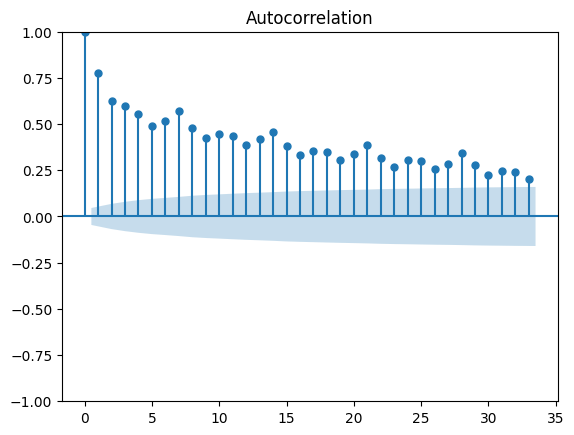

In [102]:

# Assuming 'data' is your time series data
plot_acf(df.groupby('date').mean()['streams'])
plt.show()



In [99]:
# Linear Regression

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score


# Convert 'date' to numerical features (e.g., day of the year)
df['day_of_year'] = df['date'].dt.dayofyear

# Select relevant columns
selected_columns = ['rank', 'day_of_year', 'trend', 'streams','duration_ms', 
                    'current_days_count', 'artist_followers','artist_total_tracks', 
                    'artist_popularity', 'album_names_count', 'danceability', 'energy', 
                    'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 
                    'liveness', 'valence', 'tempo',  'days_it_lasts_further','streaming_counts_lag_1']


# Separate features and target variable
X = df[selected_columns]
y = df['days_it_lasts_further']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define categorical and numerical columns for preprocessing
categorical_cols = ['trend']
numerical_cols = ['rank', 'day_of_year', 'streams','duration_ms', 'album_names_count','artist_followers','artist_total_tracks', 
                  'artist_popularity', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 
                  'liveness', 'valence', 'tempo', 'current_days_count','streaming_counts_lag_1']
                  #'streaming_counts_lag_1']

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Create a linear regression model pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', LinearRegression())])

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

In [111]:
!pip install --upgrade datetime

You should consider upgrading via the 'C:\Users\annie\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [115]:
import datetime;
lag_steps = 1
for url, track_data in df.groupby('url'):
    #track_data.set_index('date', inplace=True)
    #date_range = pd.date_range(start=track_data.index.min(), end=track_data.index.max(), freq='D')
    
    # Reindex the track's DataFrame to fill in missing dates
    #track_data = track_data.reindex(date_range)
    for i in range(1, lag_steps+1):
        #df.loc[df['url'] == url, f'streaming_counts_lag_{i}'] = track_data['streams'].shift(i)
        df.loc[df['url'] == url, f'streaming_counts_lag_{i}'] = track_data['streams'].shift(i)[ track_data.date == track_data.date.shift(i) + datetime.timedelta(days=i) ]





In [116]:
df['streaming_counts_lag_1'].fillna(subset=['streaming_counts_lag_1'], inplace=True)
print(df.columns)
df[['title','artist','date','streams','streaming_counts_lag_1','streaming_counts_lag_1_NEW']][df.title == 'Ni**as In Paris']

Index(['title', 'rank', 'date', 'artist', 'url', 'region', 'chart', 'trend',
       'streams', 'predict_days_stay', 'num_days_cumulative', 'Num_artists',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'artist_id', 'artist_followers',
       'genres', 'artist_popularity', 'type', 'album_names', 'release_dates',
       'artist_total_tracks', 'album_names_count', 'release_dates_count',
       'current_days_count', 'total_days', 'days_it_lasts_further',
       'day_of_year', 'streaming_counts_lag_1', 'streaming_counts_lag_1_NEW'],
      dtype='object')


,title,artist,date,streams,streaming_counts_lag_1,streaming_counts_lag_1_NEW
57,Ni**as In Paris,"JAY-Z, KANYE WEST",2017-01-02,132366.0,NaN,NaN
107,Ni**as In Paris,"JAY-Z, KANYE WEST",2017-01-03,142322.0,132366.0,132366.0
280,Ni**as In Paris,"JAY-Z, KANYE WEST",2017-01-07,138086.0,142322.0,NaN
486,Ni**as In Paris,"JAY-Z, KANYE WEST",2017-01-11,147544.0,138086.0,NaN
625,Ni**as In Paris,"JAY-Z, KANYE WEST",2017-01-14,151903.0,147544.0,NaN
673,Ni**as In Paris,"JAY-Z, KANYE WEST",2017-01-15,131341.0,151903.0,151903.0
727,Ni**as In Paris,"JAY-Z, KANYE WEST",2017-01-16,137639.0,131341.0,131341.0
782,Ni**as In Paris,"JAY-Z, KANYE WEST",2017-01-17,143932.0,137639.0,137639.0
829,Ni**as In Paris,"JAY-Z, KANYE WEST",2017-01-18,149599.0,143932.0,143932.0
880,Ni**as In Paris,"JAY-Z, KANYE WEST",2017-01-19,150996.0,149599.0,149599.0


In [100]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
# Create a random forest regressor pipeline
rf_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', RandomForestRegressor(random_state=42))])

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the random forest model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f'Random Forest Mean Absolute Error: {mae_rf}')

r2_rf = r2_score(y_test, y_pred_rf)
print(f'R2 Score for Random Forest: {r2_rf}')

Random Forest Mean Absolute Error: 7.582021286936236
R2 Score for Random Forest: 0.9857607419090773


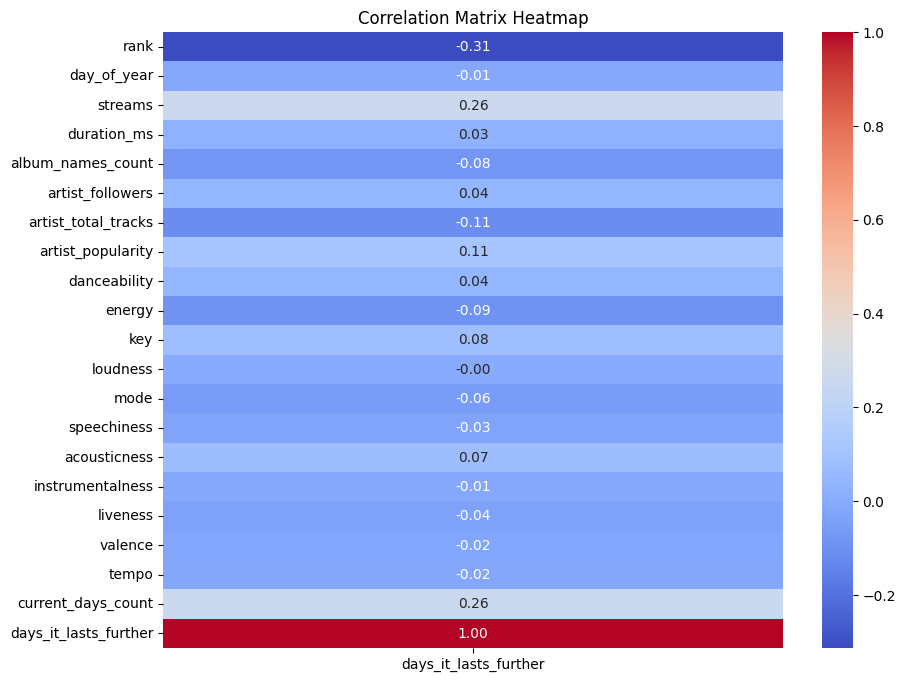

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# print(df.head())

# Assuming df is your DataFrame
correlation_matrix = df[['rank', 'day_of_year', 'streams','duration_ms', 'album_names_count','artist_followers','artist_total_tracks', 'artist_popularity', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'current_days_count', 'days_it_lasts_further']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix[['days_it_lasts_further']], annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

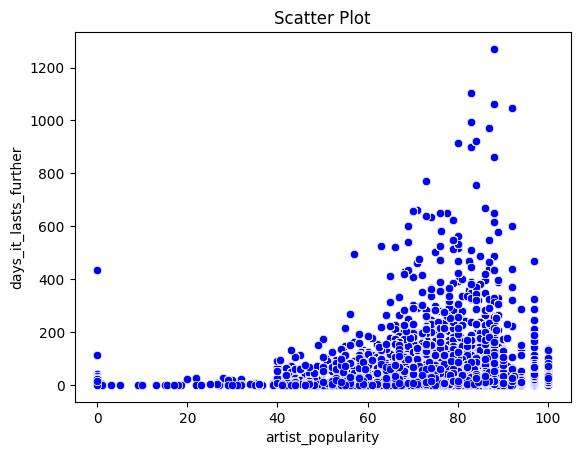

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

x_values = df['artist_popularity']
y_values = df['total_days']
sns.scatterplot(x=x_values, y=y_values, color='blue', marker='o')
plt.xlabel('artist_popularity')
plt.ylabel('days_it_lasts_further')
plt.title('Scatter Plot')
plt.show()

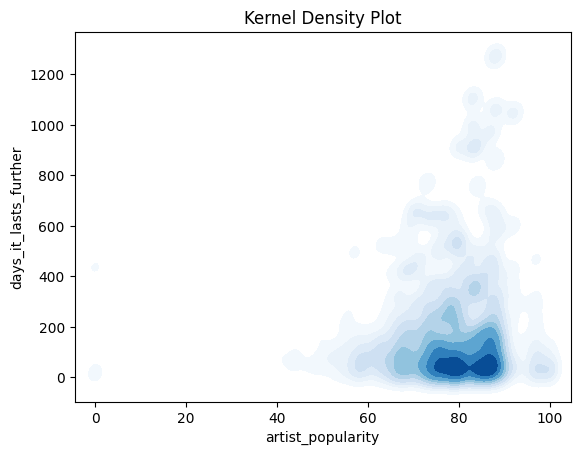

In [11]:
import seaborn as sns

x = df['artist_popularity']
y = df['total_days']
x = x.to_numpy()
y = y.to_numpy()

sns.kdeplot(x=x, y=y, cmap='Blues', fill=True)
plt.xlabel('artist_popularity')
plt.ylabel('days_it_lasts_further')
plt.title('Kernel Density Plot')
plt.show()

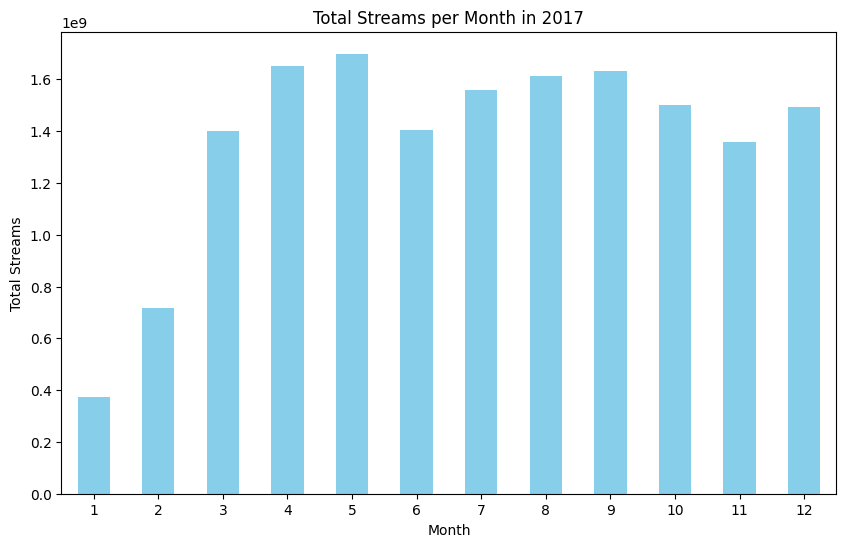

In [59]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df'
# If 'date' is not in datetime format, convert it
df['date'] = pd.to_datetime(df['date'])

# Step 1: Extract rows for the year 2017
df_2017 = df[df['date'].dt.year == 2017]

# Step 2: Group by month and sum the streams
monthly_streams = df_2017.groupby(df_2017['date'].dt.month)['streams'].sum()

# Plotting
plt.figure(figsize=(10, 6))
monthly_streams.plot(kind='bar', color='skyblue')
plt.xlabel('Month')
plt.ylabel('Total Streams')
plt.title('Total Streams per Month in 2017')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.show()


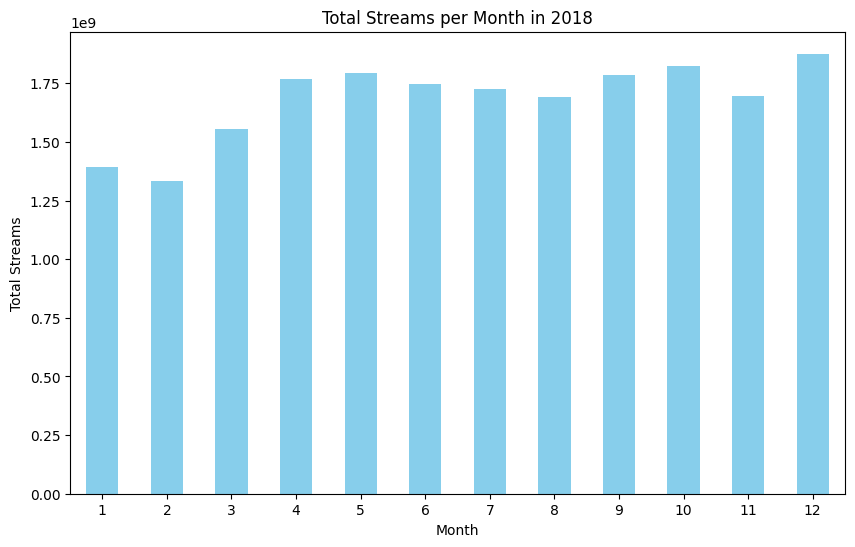

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df'
# If 'date' is not in datetime format, convert it
df['date'] = pd.to_datetime(df['date'])

# Step 1: Extract rows for the year 2017
df_2017 = df[df['date'].dt.year == 2018]

# Step 2: Group by month and sum the streams
monthly_streams = df_2017.groupby(df_2017['date'].dt.month)['streams'].sum()

# Plotting
plt.figure(figsize=(10, 6))
monthly_streams.plot(kind='bar', color='skyblue')
plt.xlabel('Month')
plt.ylabel('Total Streams')
plt.title('Total Streams per Month in 2018')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.show()


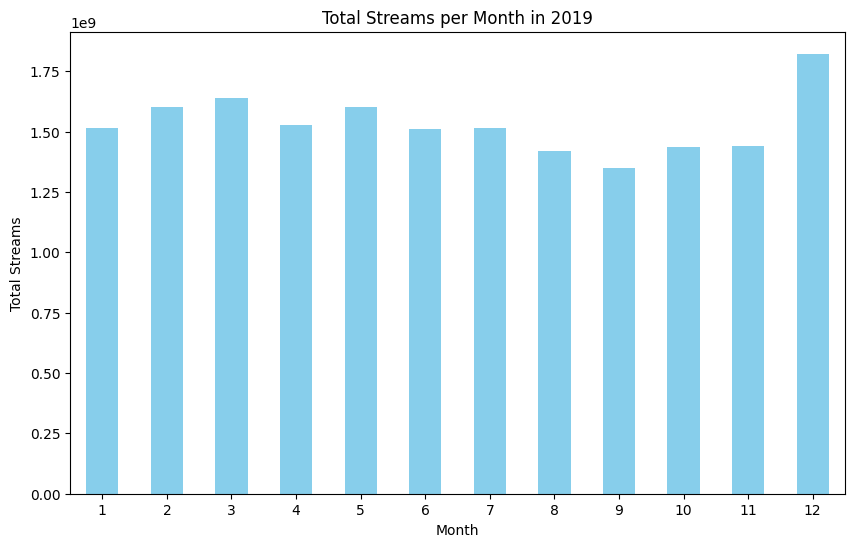

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df'
# If 'date' is not in datetime format, convert it
df['date'] = pd.to_datetime(df['date'])

# Step 1: Extract rows for the year 2017
df_2017 = df[df['date'].dt.year == 2019]

# Step 2: Group by month and sum the streams
monthly_streams = df_2017.groupby(df_2017['date'].dt.month)['streams'].sum()

# Plotting
plt.figure(figsize=(10, 6))
monthly_streams.plot(kind='bar', color='skyblue')
plt.xlabel('Month')
plt.ylabel('Total Streams')
plt.title('Total Streams per Month in 2019')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.show()


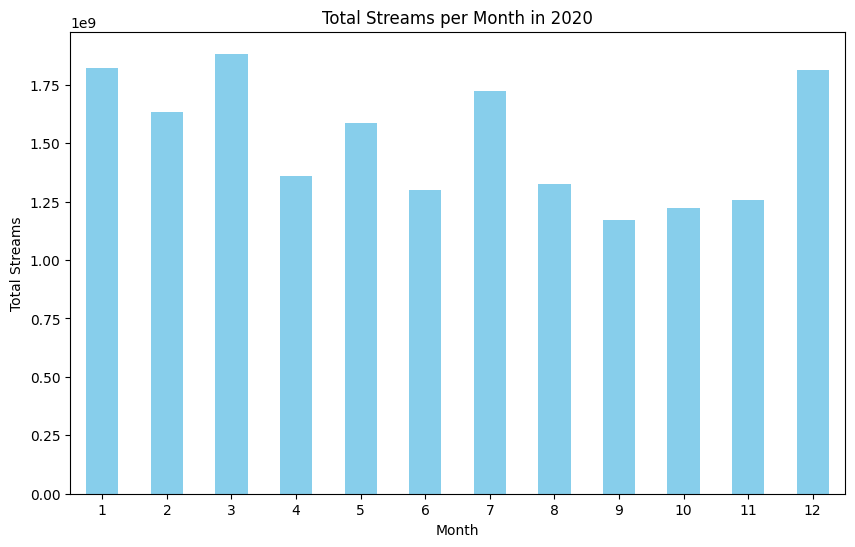

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df'
# If 'date' is not in datetime format, convert it
df['date'] = pd.to_datetime(df['date'])

# Step 1: Extract rows for the year 2017
df_2017 = df[df['date'].dt.year == 2020]

# Step 2: Group by month and sum the streams
monthly_streams = df_2017.groupby(df_2017['date'].dt.month)['streams'].sum()

# Plotting
plt.figure(figsize=(10, 6))
monthly_streams.plot(kind='bar', color='skyblue')
plt.xlabel('Month')
plt.ylabel('Total Streams')
plt.title('Total Streams per Month in 2020')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.show()

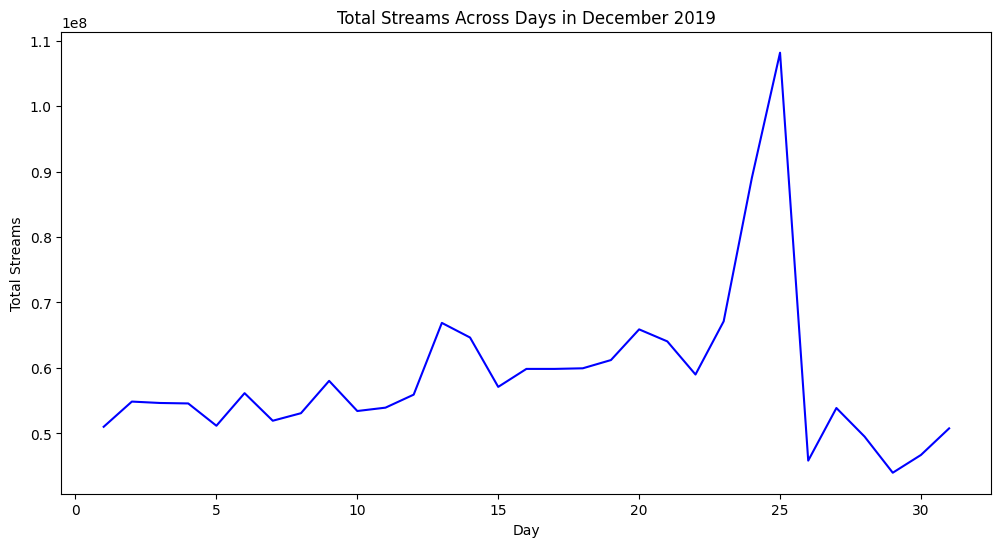

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame with 'date' and 'streams' columns
# Make sure 'date' is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Step 1: Extract rows for the year 2019 and the 12th month
df_2019_december = df[(df['date'].dt.year == 2019) & (df['date'].dt.month == 12)]

# Step 2: Group by day and sum the streams
daily_streams_december = df_2019_december.groupby(df_2019_december['date'].dt.day)['streams'].sum()

# Step 3: Plot the total streams across each day in December 2019
plt.figure(figsize=(12, 6))
daily_streams_december.plot(kind='line', color='blue')
plt.xlabel('Day')
plt.ylabel('Total Streams')
plt.title('Total Streams Across Days in December 2019')
plt.xticks(rotation=0)  # Optional: Rotate x-axis labels for better readability
plt.show()


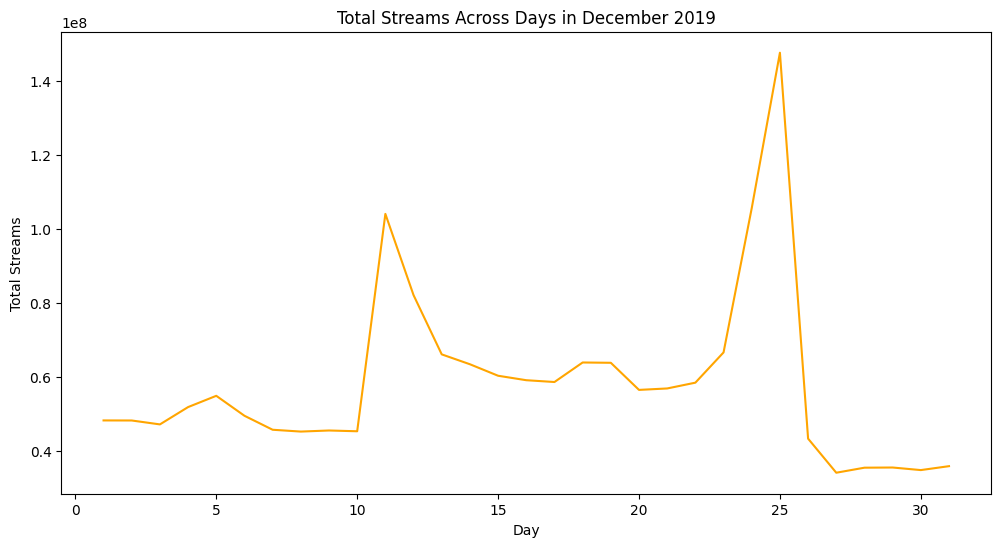

In [68]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame with 'date' and 'streams' columns
# Make sure 'date' is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Step 1: Extract rows for the year 2019 and the 12th month
df_2020_december = df[(df['date'].dt.year == 2020) & (df['date'].dt.month == 12)]

# Step 2: Group by day and sum the streams
daily_streams_december = df_2020_december.groupby(df_2020_december['date'].dt.day)['streams'].sum()

# Step 3: Plot the total streams across each day in December 2019
plt.figure(figsize=(12, 6))
daily_streams_december.plot(kind='line', color='orange')
plt.xlabel('Day')
plt.ylabel('Total Streams')
plt.title('Total Streams Across Days in December 2019')
plt.xticks(rotation=0)  # Optional: Rotate x-axis labels for better readability
plt.show()
